In [6]:
# The goal of this notebook is to lay the foundation
# for two types of supervised machine learning classifiers.
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import ast
import pandas as pd
import numpy as np

In [37]:
## Step 0: Filter Out Unneeded Cols
def condition_raw_data(raw_df):
    """
    Consume a dataframe

    Return a DF with the musical attributes and genre columns only
    """
    # rename artist genres to be called genre
    raw_df.rename(columns={'artist_genres': 'genre'}, inplace=True)
    # features and y val cols.
    required_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature',
                'duration_ms', 'genre'
       ]
    # remove unneccessary cols
    raw_df = raw_df[required_cols]

    

    return raw_df
## Step 1: Break the data into a training and a test set
def generate_train_test(tracks_df, random_val=42, split_ratio=0.8):
    """
    inputs:
        a dataframe containing song attributes and genre.
        random val for repeatability
        split_ratio = decimal pct of samples to use for training.
    returns:
        two dataframes train_df and test_df
    """
    # step 1 shuffle the df
    temp_df = tracks_df.sample(random_state=random_val, frac=1.0)
    # establish a number to split the frame at.
    num_train_samples = int(split_ratio*len(tracks_df))
    # split the DF into two sets train and test
    return np.split(temp_df, [num_train_samples])
# PCA
# goal apply PCA to the data set. Evaluate impact on F1
def apply_pca(train_df):
    """
    read in the training data for a dataframe
    apply dimmensionality reduction

    Special version for plot. Return PCA object.
    """
    # start off with stock settings
    pca = PCA(n_components=13)
    train_df.reset_index(inplace=True, drop=True)
    X_cols = [col for col in train_df.columns if col != 'genre']
    myScaler = StandardScaler()
    X_train = myScaler.fit_transform(train_df[X_cols])
    # only use the training data to fit the pca model
    pca.fit(X_train)
    return pca.transform(X_train), pca


In [38]:
# implement pca function
raw_df = pd.read_csv('../raw_spotify_data/pure_genre_data.csv')
clean_df = condition_raw_data(raw_df)
train, test = generate_train_test(clean_df, 42, 0.8)
train, pca = apply_pca(train)

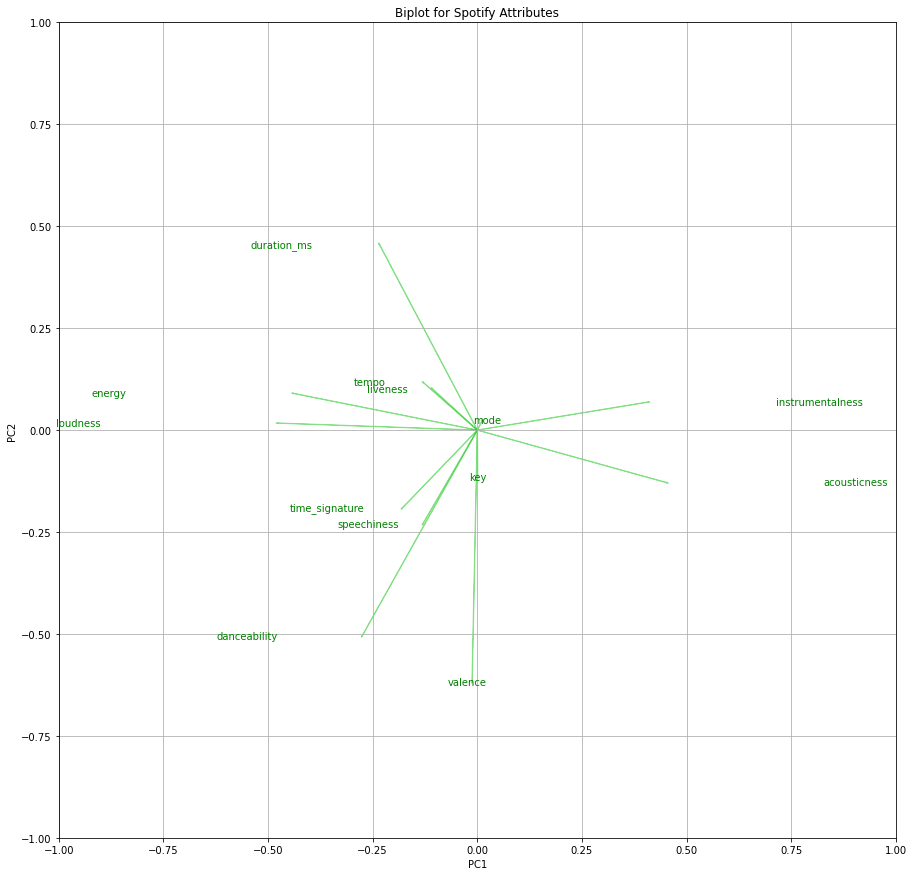

In [56]:
# generate biplot for features vs first 2 principal components

feature_names = required_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature',
                'duration_ms']

## Routine to generate a high-quality biplot
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    # this function was adapted based on the biplot used in unsupervised machine learning week 1.
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 2
    fig, ax = plt.subplots()
    ax.scatter(xs*scalex, ys*scaley, s=1, color='w')
    for i in range(n):
        ax.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='limegreen',alpha=0.5) 
        ax.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='g', ha='center', va='center')
    ax.set_title('Biplot for Spotify Attributes')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("PC{}".format(pcax))
    ax.set_ylabel("PC{}".format(pcay))
    fig.set_size_inches(15,15)
    ax.grid()

biplot(train, np.transpose(pca.components_[0:2, :]), 13, 1, 2, labels=feature_names) 
     

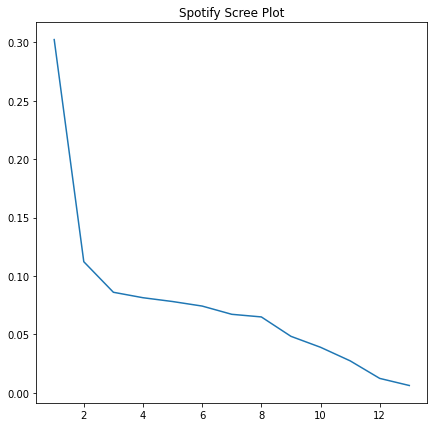

In [55]:
num_components = np.arange(pca.n_components_) + 1
fig, ax = plt.subplots()
ax.set_title('Spotify Scree Plot')
ax.plot(num_components, pca.explained_variance_ratio_)
fig.set_size_inches(7, 7)
